# Sensitivity and Complementary Sensitivtiy Functions
## today's objectives: 
- recall  main advantages of feedback
- derive and understand main feedback equation

## Assume:
- transfer function representation of a system
- working knowledge of bode plots

# Notation

![openloop](openloop.png "Open-Loop")

- $P$: plant (system)
- $u$: input (variable can be manipulated)
- $y$: output (variable to be controlled)
- $d$: disturbance (affects value of output)

![feedbackloop](feedbackloop.png "Feedback")

- $K$: controller
- $r$: reference signal (desired output)
- $n$: measurement noise (error in measurement)
- $y_m$: measured output


# Why feedback?










![AttaboticsThunderdome](attabotics-thunderdome.png "Attabotics Thunderdome")

- Ability to follow desired signals
- Stability (design)
- Reduction of effects of process noise / load disturbances (noise rejection, compensation)
- Reduction of effects of model uncertainties
- Efficiency (design)

# Let's illustrate these advantages using a simplified model a cruise control system!

![Car](car.png "Car")

source: https://www.istockphoto.com/photos/futuristic-car-isolated


![Car free body diagram](car-free-body-diagram.png "Car free body diagram")

where,
- $F_d$ is the force due to drag
- $F_f$ is the force due to friction
- $F_a$ is the force applied by the wheels

Force due to drag:
$$
\begin{align*}
F_d = k_d v 
\end{align*}
$$
where 
- $k_d$ is drag coefficient,
- $v$ is speed of the car. 

Force due to gravity:
$$
\begin{align*}
F_g = m g 
\end{align*}
$$
where 
- $m$ is mass of car,
- $g$ is acceleration due to gravity. 

Force due to friction:
$$
\begin{align*}
F_f &= k_f v F_n \\
&= k_f v F_g \\
&= k_f v m g \\
\end{align*}
$$
where 
- $F_n$ is normal force,
- $k_f$ is friction coefficient.

# In Class Activity!

Derive transfer function of the simplified car model where $F_a$ is the input and $v$ is the output.

# Putting it all together. 

Sum of forces:
$$
\begin{align*}
\sum F &= ma \\
F_a(t) - F_d(t) - F_f(t) &= ma(t) \\
F_a(t) - k_dv(t) - k_fmgv(t) &= m \frac{\text{d} v(t)}{\text{dt}} \\
F_a(t) - (k_d - k_fmg)v(t) &= m \frac{\text{d} v(t)}{\text{dt}}
\end{align*}
$$
let $k=k_d-k_fmg$, then:
$$
\begin{align*}
F_a(t) - k v(t)= m \frac{\text{d} v(t)}{\text{dt}}
\end{align*}
$$

Take Laplace transform of both sides:
$$
\begin{align*}
F_a(s) - k V(s) = m(sV(s)-v(0))
\end{align*}
$$
Rearrange:
$$
\begin{align*}
V(s) = \frac{1}{ms + k}F(s) - \frac{m}{ms + k}v(0)
\end{align*}
$$
So the transfer function of the car is:
$$
\begin{align*}
G(s) = \frac{1}{ms + k}
\end{align*}
$$





In [2]:
import control as ct
import numpy as np
import controls_teaching_lecture_utilities as cu
import math
import scipy as sp
import matplotlib.pyplot as plt

In [3]:
# Very simple model of a car (input = force applied by wheels, output = speed of car)
m = 1000 #kg
k = 500 #Ns/m

s = ct.tf('s')
Car = 1/(m*s+k)

# Controller (for cruise control)
K = 5*(m*s+k)/s


# In Class Activity

Spend some time exploring this model. Make Bode plot, S-plane plot, Unit Step Response.

# Back to: Advantages of Control

- Ability to follow desired signals (responsiveness of system)
- Stability (design)
- Reduction of effects of process noise / load disturbances (noise rejection, compensation)
- Reduction of effects of model uncertainties
- Efficiency (design)

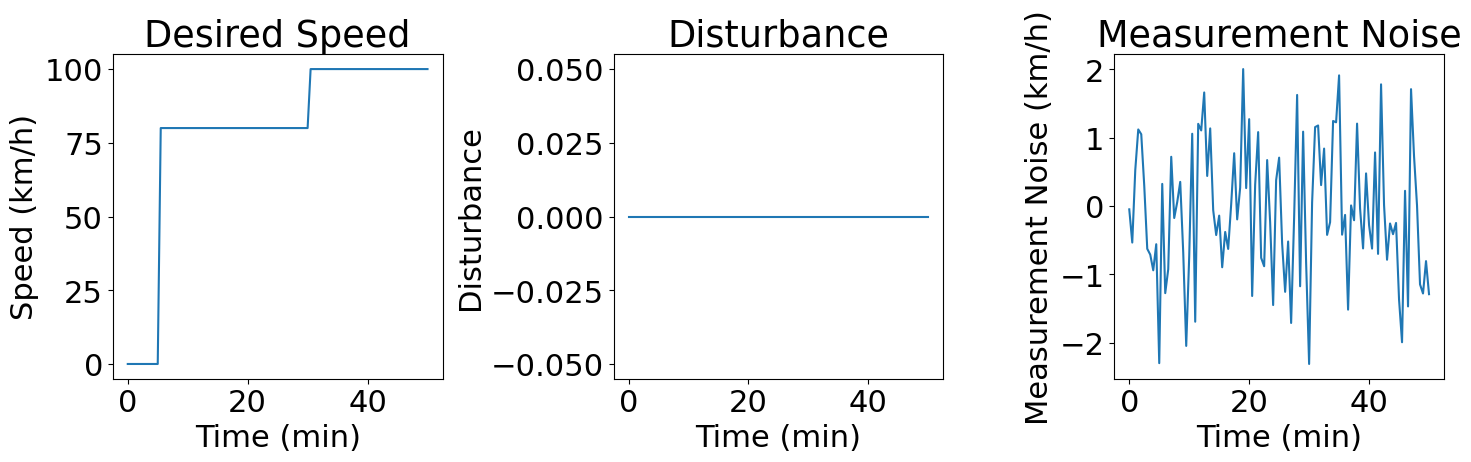

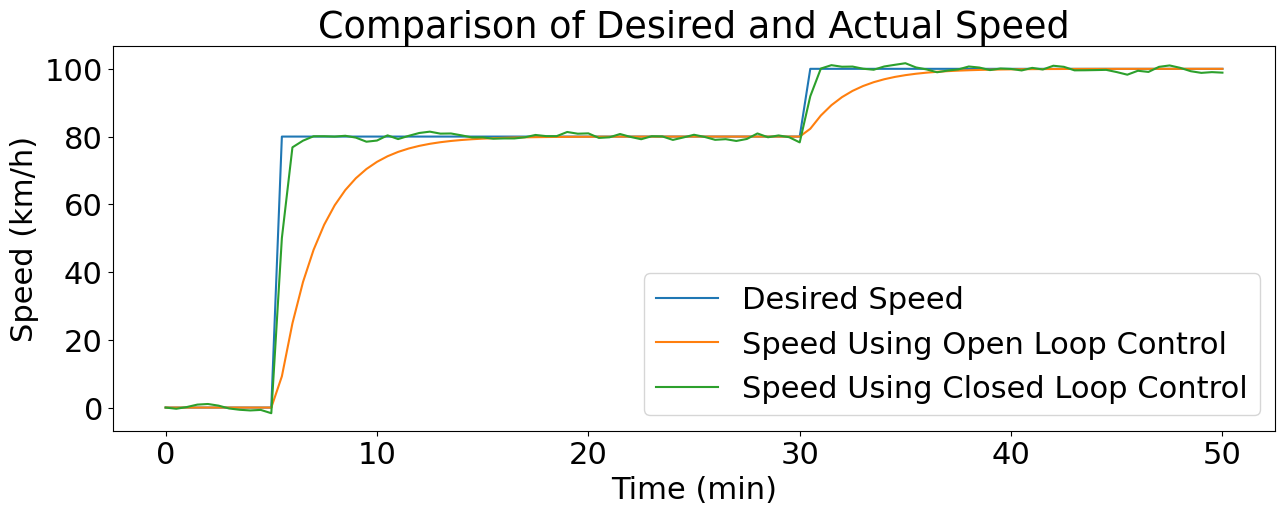

In [12]:
def sim_closed_loop(P,K,t,r,d,n):
    L = K*P
    S = 1/(1+L)
    T = L/(1+L)   

    y_r = ct.forced_response(T,t,r) 
    y_n = ct.forced_response(T,t,n) 
    y_d = ct.forced_response(P*S,t,d) 

    y = y_r.y + y_d.y + y_n.y

    u_r = ct.forced_response(K*S,t,r) 
    u_d = ct.forced_response(T,t,d) 
    u_n = ct.forced_response(K*S,t,d) 

    u = u_r.y - u_d.y - u_n.y

    return np.squeeze(y), np.squeeze(u)


def sim_open_loop(P,t,u,d):    
    y_r = ct.forced_response(P,t,u) 
    y_d = ct.forced_response(P,t,d) 
    y = np.squeeze(y_r.y) + np.squeeze(y_d.y)  
    return y


def make_open_and_closed_loop_plots(t,r,d,n,y2,y1):
    fig,ax = plt.subplots(1,3, figsize=(15,5) )
    ax[0].plot(t,r)
    ax[0].set_xlabel('Time (min)')
    ax[0].set_ylabel('Speed (km/h)')
    ax[0].set_title('Desired Speed')
    ax[1].plot(t,d)
    ax[1].set_xlabel('Time (min)')
    ax[1].set_ylabel('Disturbance')
    ax[1].set_title('Disturbance')   
    ax[2].plot(t,n)    
    ax[2].set_xlabel('Time (min)')
    ax[2].set_ylabel('Measurement Noise (km/h)')
    ax[2].set_title('Measurement Noise')
        
    fig.tight_layout()
    
    fig,ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(t,r, label='Desired Speed')
    ax.plot(t,y1, label='Speed Using Open Loop Control')   
    ax.plot(t,y2, label='Speed Using Closed Loop Control') 
    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Speed (km/h)')
    ax.set_title('Comparison of Desired and Actual Speed')
    plt.legend()


# Reference, disturbance and measurement noise signals
t = np.linspace(0, 50, 101)
r = [0 if ti <= 5 else
     80 if ti <= 30 else
     100 for ti in t]
r = np.array(r) 
d = np.zeros(101)
n = np.random.randn(101)

# simulate closed-loop and open-loop models for selected reference, disturbance and measurement noise signals
y_closed_loop, u_closed_loop = sim_closed_loop(Car,K,t,r,d,n)
y_open_loop = sim_open_loop(Car,t,r*k,d)  # need to multiply input by k to "calibrate" input force. Why? (Check v(\infty) when r is a unit step).

# plot results
make_open_and_closed_loop_plots(t,r,d,n,y_closed_loop,y_open_loop)

# Effect of disturbance (open-loop vs closed-loop)


    1000 s^2 + 500 s
------------------------
1000 s^2 + 5500 s + 2500



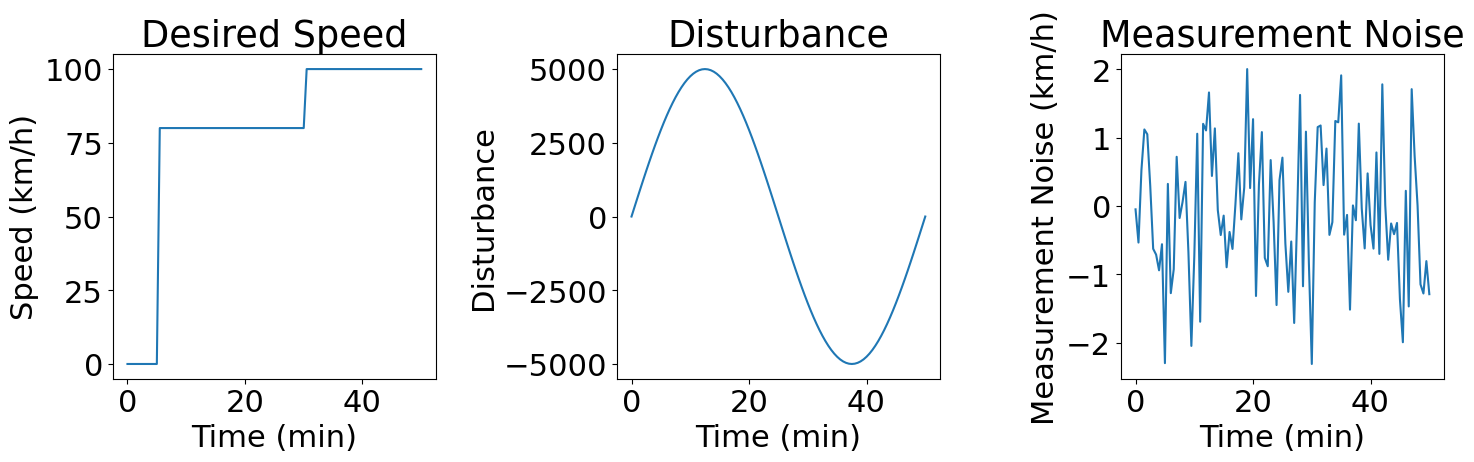

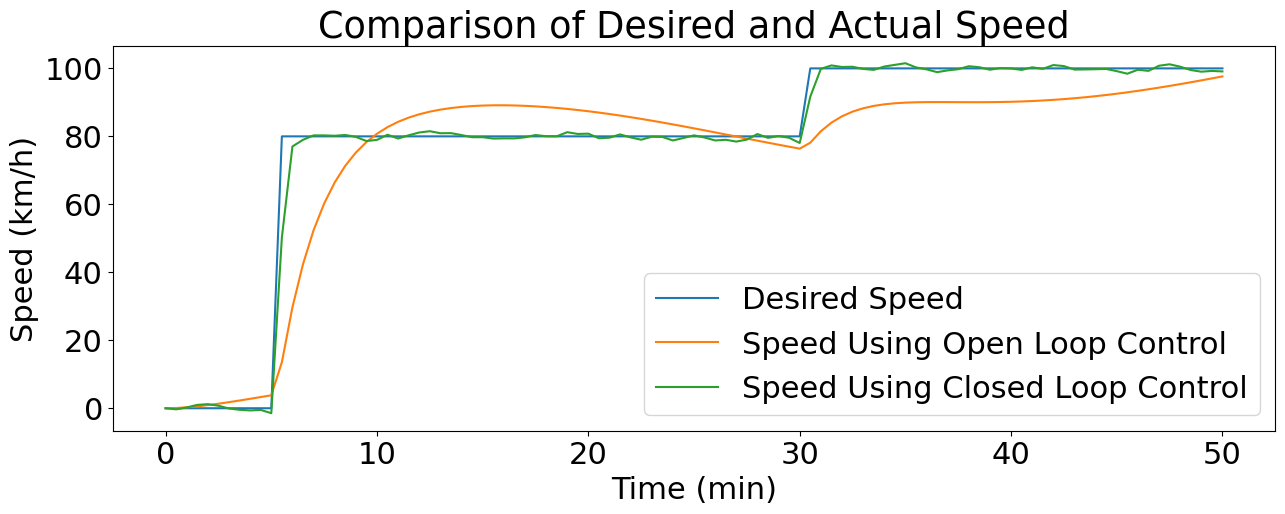

In [16]:
d_hill = 10*np.sin(t/100*np.pi*4)*k
y_closed_loop, u_closed_loop = cu.sim_closed_loop(Car,K,t,r,d_hill,n)
y_open_loop = cu.sim_open_loop(Car,t,r*k,d_hill)

cu.make_open_and_closed_loop_plots(t,r,d_hill,n,y_closed_loop,y_open_loop)

# Effect of uncertainty in the model (open-loop vs closed-loop)


    1100 s^2 + 450 s
------------------------
1100 s^2 + 5450 s + 2500



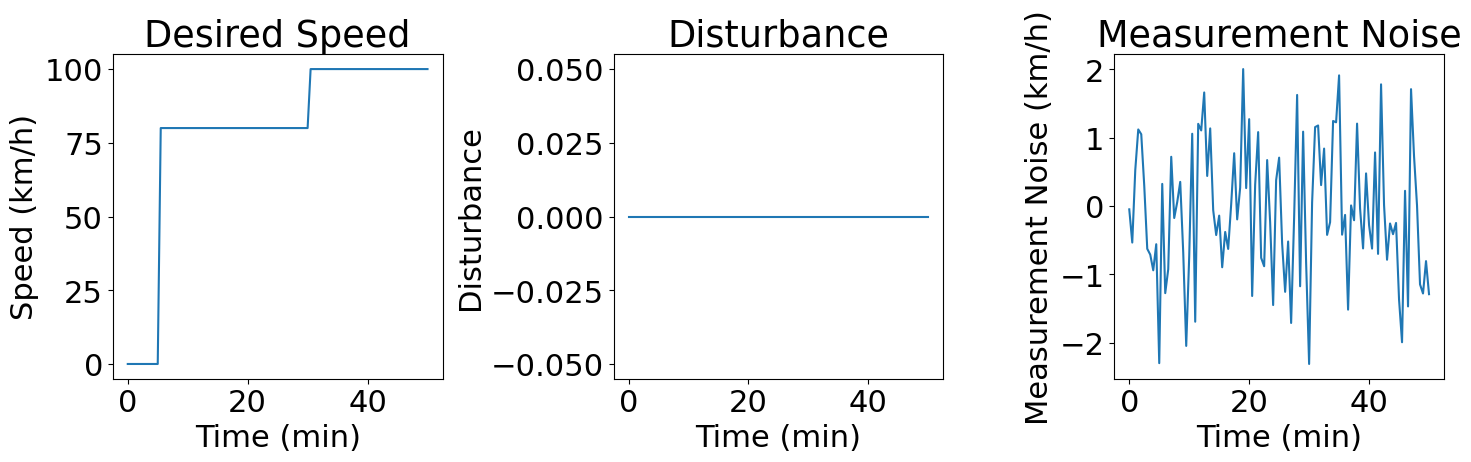

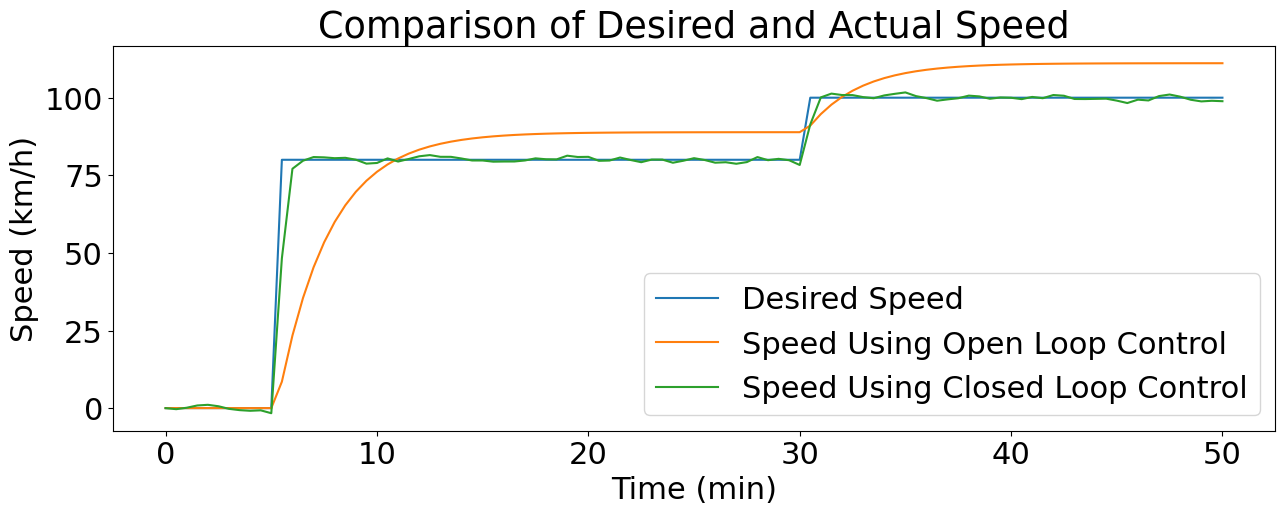

In [21]:
k = 500
k_new = 450

Car_changed = 1/(m*s+k_new)

y_closed_loop, u_closed_loop = cu.sim_closed_loop(Car_changed,K,t,r,d,n)
y_open_loop = cu.sim_open_loop(Car_changed,t,r*k,d)
    
cu.make_open_and_closed_loop_plots(t,r,d,n,y_closed_loop,y_open_loop)

# The Feedback Equation!

![feedbackloop](feedbackloop.png "Feedback")

$$
\begin{align}
y(s) &= P(s) \Big( u(s) + d(s) \Big) \\
&= P(s)K(s) \Big( r(s) - y_m(s) \Big ) + P(s)d(s) \\
&= P(s)K(s) r(s) - P(s)K(s) y_m(s) + P(s)d(s) \\
&= P(s)K(s)r(s) - P(s)K(s)\Big(y(s) + n(s)\Big) + P(s)d(s) \\
&= P(s)K(s)r(s) - P(s)K(s)y(s)  - P(s)K(s) n(s)+ P(s)d(s) \\
&= \frac{P(s)K(s)}{1+P(s)K(s)} r(s) - \frac{P(s)K(s)}{1+P(s)K(s)}n(s) + \frac{P(s)}{1+P(s)K(s)}d(s)
\end{align}
$$

Loop transfer function:

$$L(s) = P(s)K(s)$$

Sensitivity Function:

$$S(s) = \frac{1}{1+P(s)K(s)} = \frac{1}{1 + L}$$ 

Complementary Sensitivity Function:

$$T(s) = \frac{P(s)K(s)}{1+P(s)K(s)} = \frac{L}{1+L}$$ 

# Back to Feedback Equation

Express feedback equation  in terms of $T$ and $S$:

$$y(s) = T(s)r(s) - T(s)n(s) + S(s)P(s)d(s)$$

In terms of tracking error:

$$
\begin{align}
\varepsilon(s) &= r(s) - y(s) \\
&= r(s) -  T(s)r(s) - T(s)n(s) - S(s)P(s)d(s) \\
&= S(s)r(s) + T(s)n(s) - S(s)P(s)d(s)
\end{align}
$$

Observations:
- $S(s)$ determines the error due to not tracking $r$ 
- $S(s)$ determines the error due to process disturbances $d$
- $T(s)$ determines the error due to measurement noise $n$

# We want both $S(s)$ and $T(s)$ to be small!!
# However $S(s) + T(s) = 1$. 

(so we can't make both small at the same time...)


# In Class Activity!

Prove that $S(s) + T(s) = 1$.

# Let's design $K$! (Idea 1)

There are several possibilities to obtain this desired behaviour:

choose $K$ as a (large) constant.

$$\varepsilon(s) = \frac{1}{1+K(s)P(s)}r(s) - \frac{K(s)P(s)}{1+K(s)P(s)}n(s) - \frac{P(s)}{1+K(s)P(s)}d(s)$$



# In Class Activity!

Use code below to try different values of $K$

In [1]:

# Reference, disturbance and measurement noise signals
t = np.linspace(0, 50, 101)
r = [0 if ti <= 5 else
     80 if ti <= 30 else
     100 for ti in t]
r = np.array(r)
d = np.zeros(101)
n = np.random.randn(101)

# try different controllers
K = 10


y, u = cu.sim_closed_loop(Car,K,t,r,d,n)
cu.make_closed_loop_plots(t,r,d,n,y,u)

NameError: name 'np' is not defined

# In Class Activity

Derive closed loop transfer function from reference $r$ to output $v$ as a function of $K$.

From feedback equation, the transfer function from $r$ to $y$ is just $T$, so we have:
$$
\begin{align*}
Y(s) &= T(s)R(s) \\
&= \frac{P(s)K}{1 + P(s)K}
\end{align*}
$$

Express $P(s) = \frac{B(s)}{A(s)}$:
$$
\begin{align*}
Y(s) &= \frac{\frac{B(s)}{A(s)}K}{1 + \frac{B(s)}{A(s)}K} \\
&= \frac{KB(s)}{A(s) +B(s)K}
\end{align*}
$$

This is an expression of the closed-loop transfer function as a function of $K$ (where $K$ is a constant). What do we observe?
- poles of closed loop system depend on $K$
- this expression defines what behaviors we can obtain using a proportional controller (i.e. constant $K$)

We want to visualize the possible behaviors somehow! (and know what the limitations are of using a proportional controller)

Idea: 
Plot poles and zeros for a whole range of $K$ in the s-plane. This is called a Root Locus plot.

# In Class Activity

Make a root-locus plot for the cruise-control system

Numerator: [0. 1.]
Denominator: [1000  500]


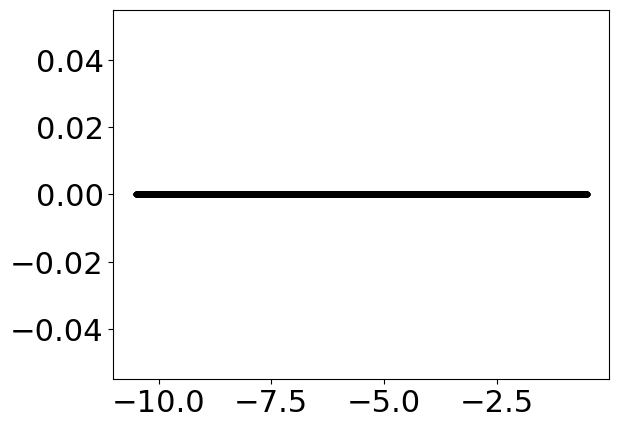

In [7]:
def enel441_root_locus(num,den,min_k,max_k):
    if len(num[0][0]) == len(den[0][0]):
        print('Nothing to do.')
        num_padded = num[0][0]
        print(num[0][0])
        print(den[0][0])
    else:
        num_padded = np.concatenate((np.zeros(len(den[0][0])-len(num[0][0])), num[0][0]))
        print('Numerator:', num_padded)
        print('Denominator:', den[0][0])

    fig, ax = plt.subplots(1,1)
    for k in range(min_k,max_k):
        den_closed_loop = den[0][0] + k*num_padded
        closed_loop_poles = np.roots(den_closed_loop)
        ax.plot(np.real(closed_loop_poles),np.imag(closed_loop_poles), 'k.' )
    
    return fig, ax


fix,ax = enel441_root_locus(Car.num,Car.den,0,10000)
plt.show()

        



# Look at another Example System - Active Suspension for a Car

![Car suspension](car_suspension.png "Car suspension")
source: https://auto.howstuffworks.com/car-suspension.htm


![Car suspension diagram](car-suspension-diagram.png "Car suspension diagram")


![Car suspension free body diagram](car-suspension-free-body-diagram.png "Car suspension free body diagram")

where,
- $F_u$ is the force applied by the active suspension
- $F_g$ is the force due to gravity
- $F_s$ is the force due to the spring
- $F_d$ is the force due to the damper

Force due to drag:
$$
\begin{align*}
F_d = k_d v 
\end{align*}
$$
where 
- $k_d$ is drag coefficient,
- $v$ is speed of the car. 


In [39]:
ks = 900 #N/m
kd = 7.5 #Ns/m 
m = 2.45 #kg

A = np.array([[0, 1], [ks/m, kd/m]])
B = np.array([[-1, 0], [-1/m, 1/m]])
C = np.array([[ks/m, kd/m]])
D = np.array([[-1/m, 1/m]])

Suspension_ss = ct.StateSpace(A,B,C,D)



print(Suspension_tf)

[[  0.           1.        ]
 [367.34693878   3.06122449]]


UFuncTypeError: Cannot cast ufunc 'inv' input from dtype('O') to dtype('float64') with casting rule 'same_kind'

# Material for next lecture

# Balancing Priorities

$$\varepsilon(s) =S(s)r(s) + T(s)n(s) - S(s)P(s)d(s)$$

![FrequencyDomainRepresentationDesiredSensitivity](sensitivityBode.png "Frequency Domain Representation of Desirable Sensitivity Function")

# That is great insight!
# However, how does this help us? Our ''tuning knob'' is the controller K...

In [ ]:
L = 1/s

S = 1/(1+L)
T = L/(1+L)
mag, phase, omega = bode([S, T], dB=True, plot=False)

fig, ax = plt.subplots(1,1, figsize = [10,5])
ax.semilogx(omega[0],[20*math.log10(x) for x in mag[0]], label='Sensitivity Function')
ax.semilogx(omega[1],[20*math.log10(x) for x in mag[1]], label='Complementary Sensitivity Function')
#ax.semilogx(omega[0],mag[0], label='Sensitivity Function')
#ax.semilogx(omega[1],mag[1], label='Complementary Sensitivity Function')
ax.set_xlabel('Frequency (rad/s)')
ax.set_ylabel('Magnitude (dB)')
ax.set_title('Bode Plot')
plt.legend(bbox_to_anchor=(1.05,1), borderaxespad=0)
plt.show()

# How does $K$ affect frequency response of $S$ and $T$?

$$
\begin{align}
S(s) &= \frac{1}{1+L(s)}  = \frac{1}{1+P(s)K(s)} \\
T(s) &= \frac{L(s)}{1+L(s)} = \frac{P(s)K(s)}{1+P(s)K(s)}  
\end{align}
$$

In [ ]:
L = 1/s

S = 1/(1+L)
T = L/(1+L)
mag, phase, omega = bode([S, T, L], dB=True, plot=False)



fig, ax = plt.subplots(1,1, figsize = [10,5])
ax.semilogx(omega[0],[20*math.log10(x) for x in mag[0]], label='Sensitivity Function')
ax.semilogx(omega[1],[20*math.log10(x) for x in mag[1]], label='Complementary Sensitivity Function')
ax.semilogx(omega[2],[20*math.log10(x) for x in mag[2]], label='Loop Transfer Function')
#ax.semilogx(omega[0],mag[0], label='Sensitivity Function')
#ax.semilogx(omega[1],mag[1], label='Complementary Sensitivity Function')
ax.set_xlabel('Frequency (rad/s)')
ax.set_ylabel('Magnitude (dB)')
ax.set_title('Bode Plot')
plt.legend(bbox_to_anchor=(1.05,1), borderaxespad=0)
#ax.grid(True)
plt.show()

![FrequencyDomainRepresentationDesiredLoop](desiredLoopTF.png "Frequency Domain Representation of Desirable Loop Function")

# Let's design $K$! (Idea 2)

![FrequencyDomainRepresentationDesiredLoop](desiredLoopTF.png "Frequency Domain Representation of Desirable Loop Function")

One possible loop transfer function that has our desired behaviour:

$$L(s) = \frac{1}{s}$$

(recall that this is the TF of an integrator)

But 
$$L(s) = K(s)P(s)$$
so can we solve for K?

Future topic: pole placement

In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import math


(0.999285366048076-0.037798904774643455j)
(1.4124976-0.040179603j)
(1.4099694-0.093541756j)
Using given axis.


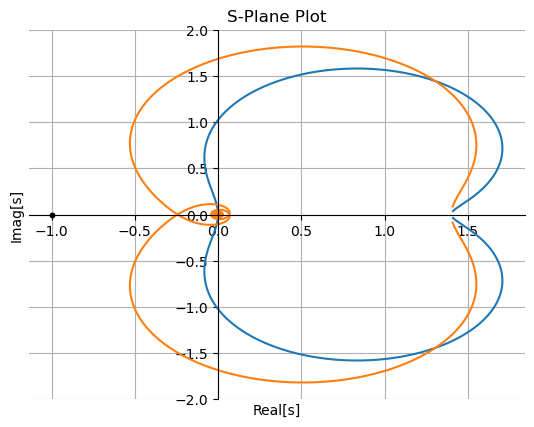

In [15]:
def my_fourier_transform(num,den,omega):
    N = omega.shape[0]
    G_jw = np.zeros(N,dtype=np.csingle)
       
    ii = 0
    for w in omega:
        jomega = 1j*w
        num_jw = 0
        jj = num.shape[0] - 1
        for nn in num:
            num_jw += nn*(jomega**jj)
            jj -= 1
        
        den_jw = 0
        jj = den.shape[0] - 1
        for dd in den:
            den_jw += dd*(jomega**jj)
            jj -= 1
        #print(den_jw)
        #print(num_jw)
        G_jw[ii] = num_jw/den_jw
        ii += 1
    return G_jw




def my_nyquist_plot(G_jw,omega,ax=[],fig=[]):
    if ax:
        print('Using given axis.')
    else:
        fig, ax = plt.subplots(1,1)
    
    ax.plot(np.real(G_jw), np.imag(G_jw))
    cur_color = ax.lines[-1].get_color()
    ax.plot(np.real(G_jw), -np.imag(G_jw),color=cur_color)

    ax.grid(True)
    ax.spines['left'].set_position('zero')
    # turn off the right spine/ticks
    ax.spines['right'].set_color('none')
    ax.yaxis.tick_left()
    # set the y-spine
    ax.spines['bottom'].set_position('zero')

    # turn off the top spine/ticks
    ax.spines['top'].set_color('none')
    ax.xaxis.tick_bottom()
    ax.set_title('S-Plane Plot')
    ax.set_xlabel('Real[s]')
    ax.set_ylabel('Imag[s]')

    ax.xaxis.set_label_coords(0.5,-0.01)
    ax.yaxis.set_label_coords(-0.01,0.5)

    ax.plot(-1,0,'k.')
    return fig, ax

num_sys = np.array([2, 7])
den_sys = np.array([1, 2, 5])

roots_den = np.roots(den_sys)
roots_num = np.roots(num_sys)
den_corner_freqs = np.abs(roots_den)
num_corner_freqs = np.abs(roots_num)

N = 1000
omega_min = np.min( [np.min(den_corner_freqs), np.min(num_corner_freqs)] )
omega_max = np.max( [np.max(den_corner_freqs), np.max(num_corner_freqs)] )
omega = np.logspace(np.log10(omega_min/10),np.log10(omega_max*100),num=N)

G_jw = my_fourier_transform(num_sys,den_sys,omega)

delay = np.exp(-complex(0,math.pi/4/5)*omega)
G_jw_rot = np.zeros(N,dtype=np.csingle)
for ii in range(N):
    G_jw_rot[ii] = G_jw[ii]*delay[ii]

print(delay[10])
print(G_jw[10])
print(G_jw_rot[10])

fig,ax = my_nyquist_plot(G_jw,omega)
fig,ax = my_nyquist_plot(G_jw_rot,omega,ax=ax,fig=fig)

In [12]:
complex(1,1)

(1+1j)

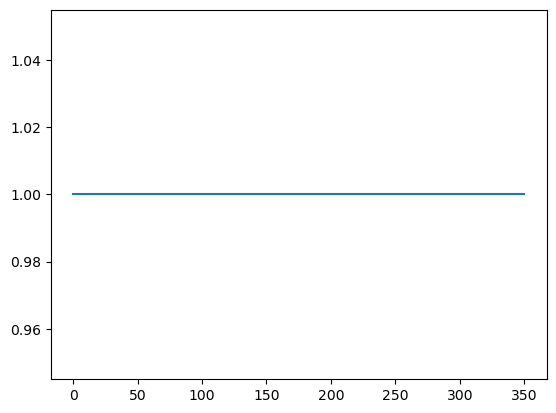

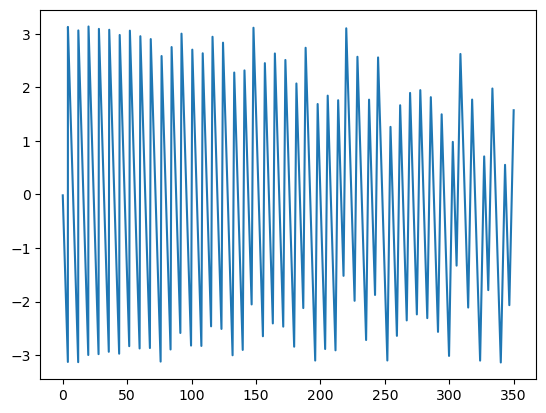

In [22]:

fig,ax = plt.subplots(1,1)
ax.plot(omega,np.abs(delay))
fig,ax = plt.subplots(1,1)
ax.plot(omega,np.angle(delay))
